# ACA-Py & ACC-Py Basic Template

## Copy this template into the root folder of your notebook workspace to get started

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
import asyncio
import nest_asyncio
from termcolor import colored

nest_asyncio.apply()

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://hlgf-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Store Issuing Schema and Cred Def Identifiers

If you intend for this agent to issue credentials you should first initialise your agent as an issuer and author the relevant identifiers to the public ledger. The issuer_initialisation recipe notebook can be duplicated and used as a starting point.

Once schema and cred def identifiers are created copy across and store in variables as illustrated in the cell below. Be sure to use unique names for each variable.

In [4]:
schema_id='W4t2Pa4XR1qBDvwhVcn4CY:2:Aries ACA ACC Jupyter Playground Demo Participation:0.0.1'
cred_def_id='32WXnYANVbibAjvhpc6nvA:3:CL:216849:default'



# %store schema_id
# %store <cred_def_id>

## Create Multi-Use Invite

Before you can issue a credential you must first establish a connection across which the credential will be issued to a holder. (see recipes/connection)

In [5]:
# Alias for invited connection
alias = "Participant"
auto_accept = "true"
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "true"

multi_use_invite_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()


multi_use_invititation_key = multi_use_invite_response["invitation"]["recipientKeys"][0]

print(multi_use_invititation_key)

7TNneHRgUHsxb88davdbpMR44dnGp77FR844JSij71MC


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and fill in additional logic as needed.

In [6]:
listeners = []

In [7]:
import time

## YOUR LISTENERS HERE
# Receive connection messages
def connections_handler(payload):
    state = payload['state']
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]
    
    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")
    
    print(payload)
    loop = asyncio.get_event_loop()

    if state == "response":
        time.sleep(2)
        loop.run_until_complete(agent_controller.messaging.trust_ping(connection_id))
        
    if state == "active":
        # Your business logic
        invitation_key = payload["invitation_key"]
        their_lablel = payload["their_label"]
        print(invitation_key)
        if invitation_key == multi_use_invititation_key:
            event_name = "Hyperledger Global Forum 2021"
            issue_date= date.today().isoformat()
            credential_attributes = [
                {"name": "Event Name", "value": event_name},
                {"name": "Participant", "value": their_lablel},
                {"name": "Description", "value": "Thank you for attending the Aries Jupyter Playground demo at HGF 2021"},
                {"name": "Date", "value": issue_date}
            ]
            
            # Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
            trace = False
            comment = ""
            # Remove credential record after issued?
            auto_remove = True

            # Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
            loop.run_until_complete(agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, comment, auto_remove, trace))
        print(colored("Connection ID: {0} is now active.".format(connection_id), "green", attrs=["bold"]))

connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

listeners.append(connection_listener)

In [8]:
from datetime import date

def issuer_handler(payload):
    connection_id = payload['connection_id']
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    print("\n---------------------------------------------------\n")
    print("Handle Issue Credential Webhook")
    print(f"Connection ID : {connection_id}")
    print(f"Credential exchange ID : {exchange_id}")
    print("Agent Protocol Role : ", role)
    print("Protocol State : ", state )
    print("\n---------------------------------------------------\n")
    loop = asyncio.get_event_loop()
    if state == "proposal_received":
        print(f'Proposal Comment : {payload["credential_proposal_dict"]["comment"]}')
        proposed_cred_def_id = payload["credential_proposal_dict"]["cred_def_id"]
        proposed_schema_id = payload["credential_proposal_dict"]["schema_id"]
        
        if proposed_cred_def_id == cred_def_id and proposed_schema_id == schema_id:
            for attribute in payload["credential_proposal_dict"]["credential_proposal"]["attributes"]:
                if attribute["name"] == "Participant":
                    participant = attribute["value"]
                elif attribute["name"] == "Description":
                    description = attribute["value"]
                    description += "\n Thanks for attending!"


            event_name = "Hyperledger Global Forum 2021"
            issue_date= date.today().isoformat()
            credential_attributes = [
                {"name": "Event Name", "value": event_name},
                {"name": "Participant", "value": participant},
                {"name": "Description", "value": description},
                {"name": "Date", "value": issue_date}
            ]

            print(credential_attributes)

            # Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
            trace = False
            comment = ""
            # Remove credential record after issued?
            auto_remove = True

            # Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
            loop.run_until_complete(agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, comment, auto_remove, trace))
        else:
            explaination = "You have not referenced the correct schema and credential definitions"
            loop.run_until_complete(agent_controller.issuer.send_problem_report(exchange_id, explaination))
        
    
    elif state == "offer_sent":
        proposal = payload["credential_proposal_dict"]
        attributes = proposal['credential_proposal']['attributes']

        print(f"Offering credential with attributes  : {attributes}")
        ## YOUR LOGIC HERE
    elif state == "request_received":
        print("Request for credential received")
        ## YOUR LOGIC HERE
    elif state == "credential_sent":
        print("Credential Sent")
        ## YOUR LOGIC HERE
    
issuer_listener = {
    "topic": "issue_credential",
    "handler": issuer_handler
}

listeners.append(issuer_listener)

In [9]:
agent_controller.register_listeners(listeners)

## Share Invitation Object with External Agent

In [ ]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

## Display Invite as QR Code

This is useful if you wish to issue a credential to a mobile wallet.

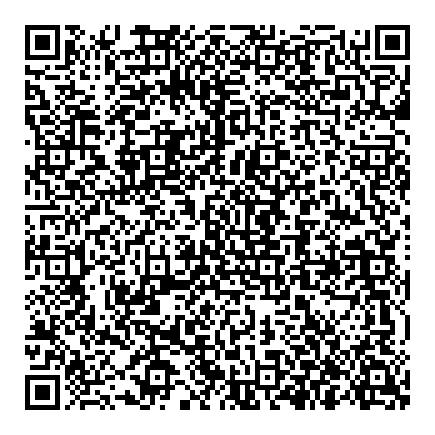

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  aa984d6d-f354-4e8a-b1a5-968208ee4970
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
{'accept': 'auto', 'their_role': 'invitee', 'invitation_key': '7TNneHRgUHsxb88davdbpMR44dnGp77FR844JSij71MC', 'routing_state': 'none', 'created_at': '2021-06-04 11:43:51.426427Z', 'my_did': 'WwfjAL1VBmn1GNrxsMi5rA', 'state': 'invitation', 'invitation_mode': 'once', 'connection_id': 'aa984d6d-f354-4e8a-b1a5-968208ee4970', 'rfc23_state': 'invitation-sent', 'updated_at': '2021-06-04 11:43:51.426427Z'}
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  aa984d6d-f354-4e8a-b1a5-968208ee4970
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
{'accept': 'auto', 'their_role': 'invitee', 'invitation_key':

In [10]:
import qrcode
# Link for connection invitation
invitation_url = multi_use_invite_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [11]:
await agent_controller.terminate()